###Выполнил Мусаев Руслан


##Предсказание поведения сервиса

Описание колонок в файле:
 
timestamp - календарное время снятия показаний работы сервиса в формате time_t.
conns - текущее количество соединений клиентов.
count - полное количество обработанных запросов клиентов с момента старта сервиса.
read_bytes_total - полное количество байт, прочитанных сервисом с момента старта.
latency_ms_sum - полное время обработки всех запросов клиентов с момента старта сервиса.
 
задача:
1.       Построить одну или несколько моделей, предсказывающих следующее значение целевой метрики latency_ms_sum в зависимости от предыдущих значений всех остальных метрик.
2.       Построить на одном графике реальное значение метрики latency_ms_sum и предсказанное.
3.       Построить график ошибки предсказаний в зависимости от календарного времени.
4.       Найти все интервалы времени аномального поведения сервиса и отобразить их на графике метрики latency_ms_sum в зависимости от календарного времени.


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [46]:
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1hc9-ziEgJs5q_H9LvnIp1obRGsCEV7iW" -o 'predict.csv' 
import pandas as pd
data = pd.read_csv('/content/predict.csv')
print('\n', data.head(5))

awk: cannot open ./cookie (No such file or directory)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    741      0 --:--:-- --:--:-- --:--:--   740
100  464k  100  464k    0     0   584k      0 --:--:-- --:--:-- --:--:--  584k

     timestamp       count  conns  read_bytes_total  latency_ms_sum
0  1564650000  88967916.0  349.0      1.081355e+13     509146850.3
1  1564650300  88989154.0  336.0      1.081708e+13     509262088.5
2  1564650600  89004769.0  333.0      1.081963e+13     509341201.7
3  1564650900  89020289.0  330.0      1.082215e+13     509415425.9
4  1564651200  89026526.0  311.0      1.082481e+13     509483841.9


In [47]:
#Посмотрим на тип данных, количество nan'ов
print('type')
print(data.dtypes)
print('------------')
print('len of dataset')
print(len(data))
print('------------')
print('number of nans')
print(data.isnull().sum())

#интерполяция пробелов в данных линейной функцией
data.interpolate(method='linear', inplace=True) 
gt = data['latency_ms_sum']
data.drop('latency_ms_sum', axis = 1, inplace = True)

type
timestamp             int64
count               float64
conns               float64
read_bytes_total    float64
latency_ms_sum      float64
dtype: object
------------
len of dataset
8352
------------
number of nans
timestamp             0
count               362
conns               362
read_bytes_total    362
latency_ms_sum      362
dtype: int64


In [48]:
TEST_SIZE = 0.5
X_timestap_train, X_timestap_test = train_test_split(data['timestamp'], test_size = TEST_SIZE, shuffle = False)
data.drop('timestamp', axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=TEST_SIZE, shuffle = False)

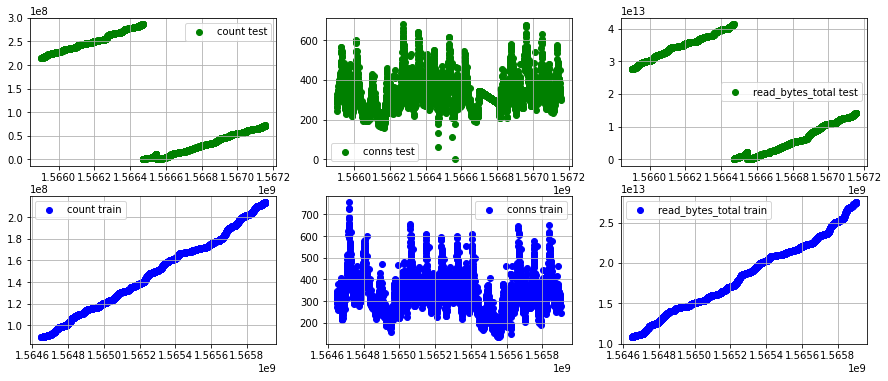

In [49]:
#посмотрим на временную зависимость признаков
size = len(data.columns)
fig, axes = plt.subplots(nrows = 2, ncols = size, figsize=(15, 6))
for feature in range(size):
  axes[0, feature].scatter(X_timestap_test, X_test[data.columns[feature]] , label = data.columns[feature] + ' test', color = 'green')
  axes[0, feature].legend()
  axes[0, feature].grid()

  axes[1, feature].scatter(X_timestap_train, X_train[data.columns[feature]] , label = data.columns[feature] + ' train', color = 'blue')
  axes[1, feature].legend()
  axes[1, feature].grid()


##1.Построить одну или несколько моделей, предсказывающих следующее значение целевой метрики latency_ms_sum в зависимости от предыдущих значений всех остальных метрик.

#Baseline - Linear Regression

In [50]:
regression = LinearRegression()
regression.fit(X_train, y_train,)
print('test subset R2 score:', regression.score(X_test, y_test,))
print('train subset R2 score:', regression.score(X_train, y_train))
print('regression.coefficient:', regression.coef_)

prediction = regression.predict(X_test)
gt_prediction = regression.predict(X_train)

print('test subset MAE:', mean_absolute_error(y_test, prediction))
print('train subset MAE:', mean_absolute_error(y_train, gt_prediction))

test subset R2 score: 0.978510140715073
train subset R2 score: 0.9838497072665384
regression.coefficient: [ 5.87563637e+00 -4.90243686e+04 -5.01455361e-06]
test subset MAE: 79882763.23019877
train subset MAE: 19245113.466431197


##2.Построить на одном графике реальное значение метрики latency_ms_sum и предсказанное.

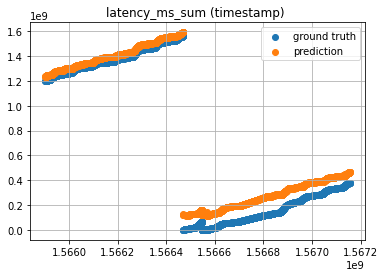

In [52]:
plt.scatter(X_timestap_test, y_test,  label = 'ground truth')
plt.scatter(X_timestap_test, prediction, label = 'prediction')
plt.title('latency_ms_sum (timestamp) ')
plt.grid()
plt.legend();

#LASSO

test subset R2 score: 0.9731521098532309
train subset R2 score: 0.9838186793339453
regression.coefficient: [ 5.26039305e+00 -4.59267569e+04 -1.41959867e-07] 



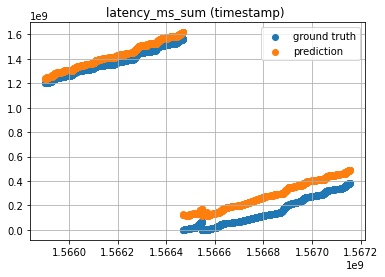

In [62]:
regression = linear_model.Lasso(alpha=0.1, max_iter = 10000, tol = 0.01)
regression.fit(X_train, y_train,)
print('test subset R2 score:', regression.score(X_test, y_test))
print('train subset R2 score:', regression.score(X_train, y_train))

print('regression.coefficient:', regression.coef_, '\n')
predictions = regression.predict(X_test)

plt.scatter(X_timestap_test, y_test,  label = 'ground truth')
plt.scatter(X_timestap_test, predictions, label = 'prediction')
plt.title('latency_ms_sum (timestamp) ')
plt.grid()
plt.legend();

#XGBRegressor

test subset R2 score: 0.7485763951643247
train subset R2 score: 0.9999579756539007 



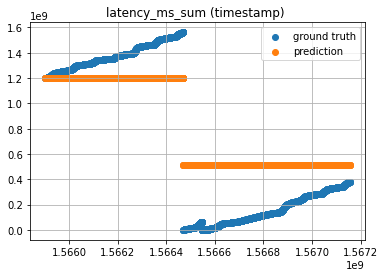

In [69]:
from xgboost import XGBRegressor

regression = XGBRegressor(objective ='reg:squarederror')
regression.fit(X_train, y_train, eval_metric ='mae',)
print('test subset R2 score:', regression.score(X_test, y_test))
print('train subset R2 score:', regression.score(X_train, y_train), '\n')
predictions = regression.predict(X_test)

plt.scatter(X_timestap_test, y_test,  label = 'ground truth')
plt.scatter(X_timestap_test, predictions, label = 'prediction')
plt.title('latency_ms_sum (timestamp) ')
plt.grid()
plt.legend();

##3.Построить график ошибки предсказаний в зависимости от календарного времени.

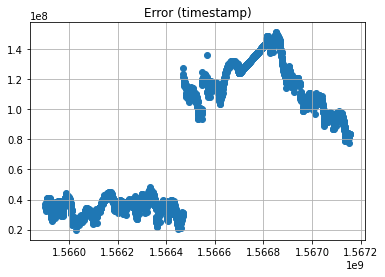

In [29]:
#выберем лучшую модель
regression = LinearRegression()
regression.fit(X_train, y_train,)
predictions = regression.predict(X_test)

plt.scatter(X_timestap_test, predictions-y_test)
plt.grid()
plt.title('Error (timestamp)');

##4.Найти все интервалы времени аномального поведения сервиса и отобразить их на графике метрики latency_ms_sum в зависимости от календарного времени.

8352
anomaly indexes [6068, 6324, 6388]


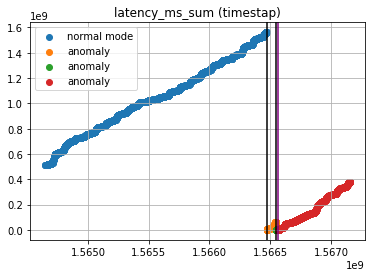

In [71]:
print(len(gt))
anomaly_timestaps = []
for j in range(1, len(gt)):
  if gt[j]<gt[j-1]:
    anomaly_timestaps.append(j)
print('anomaly indexes', anomaly_timestaps)

timestaps = pd.concat((X_timestap_train, X_timestap_test))
anomaly = list(timestaps[anomaly_timestaps])
plt.scatter(timestaps[:anomaly_timestaps[0]], gt[:anomaly_timestaps[0]], label = 'normal mode')
plt.scatter(timestaps[anomaly_timestaps[0]:anomaly_timestaps[1]], gt[anomaly_timestaps[0]:anomaly_timestaps[1]], label = 'anomaly')
plt.scatter(timestaps[anomaly_timestaps[1]:anomaly_timestaps[2]], gt[anomaly_timestaps[1]:anomaly_timestaps[2]], label = 'anomaly')
plt.scatter(timestaps[anomaly_timestaps[2]:], gt[anomaly_timestaps[2]:], label = 'anomaly')
plt.grid()
plt.axvline(x = anomaly[0], c = 'black')
plt.axvline(x = anomaly[1], c = 'black')
plt.axvline(x = anomaly[2], c = 'purple')
plt.title('latency_ms_sum (timestap)')
plt.legend();